In [72]:
%pylab inline
import string
import pandas as pd
import numpy as np
import os
import random
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import davies_bouldin_score
from sklearn import datasets
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from pprint import pprint
from xgboost import XGBClassifier
from gensim.models import Phrases, LdaModel
from gensim.corpora import Dictionary
import nltk
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import brown
from nltk import FreqDist
from wordcloud import WordCloud 
from collections import OrderedDict
import glob
import nltk
from sklearn.decomposition import PCA
from pyclustering.cluster import cluster_visualizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import MiniBatchKMeans
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import warnings
warnings.filterwarnings("ignore")

Populating the interactive namespace from numpy and matplotlib


/opt/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random', 'text']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [73]:
path = "./All Docs"
# Creating a Df with 5 columns: Directory, Category, FileName, Title, Text

categories = []
titles = []
all_data = []
#df = pd.DataFrame()
# dirname
for dirname, categoryname, filenames in os.walk(path,topdown=False):
    # filename
    for filename in filenames:
        # Absolute path
        current_file = os.path.abspath(os.path.join(dirname, filename))
        open_file = open(current_file, 'r', encoding="latin-1")
        # text_data
        text_data = open_file.read().split('\n')
        text_data = list(filter(None, text_data))
        titles.append(text_data[0])
        all_data.append((dirname, dirname.rsplit('/',1)[1], filename, text_data[0], text_data[1:]))
        #data_df = f"Directory: {dirname}, Category: {dirname.rsplit('/',1)[1]}, FileName: {filename}, Title: {text_data[0]}, Text: {text_data[1:]}"
        #print(data_df)
        
df = pd.DataFrame(all_data, columns=['directory', 'category', 'fileName', 'title', 'text'])
df['text'] = df.text.astype(str)
#print(df.head())  
#df.drop( df[ df['directory'] == "./All Docs" ].index, inplace=True)

label = np.array(df.category.shape)

print(df)



      directory  category              fileName  \
0    ./All Docs  All Docs        medical_67.txt   
1    ./All Docs  All Docs      politics_209.txt   
2    ./All Docs  All Docs  entertainment_39.txt   
3    ./All Docs  All Docs      politics_221.txt   
4    ./All Docs  All Docs  entertainment_11.txt   
..          ...       ...                   ...   
896  ./All Docs  All Docs       medical_102.txt   
897  ./All Docs  All Docs  entertainment_20.txt   
898  ./All Docs  All Docs      politics_210.txt   
899  ./All Docs  All Docs  entertainment_34.txt   
900  ./All Docs  All Docs      politics_204.txt   

                                                 title  \
0    In article <1993Mar29.204003.26952@tijc02.uucp...   
1                    Abbas 'will not tolerate' attacks   
2                    George Michael to perform for BBC   
3                     Clarke defends terror detentions   
4                      Campaigners attack MTV 'sleaze'   
..                                     

In [74]:
df.describe()  

,directory,category,fileName,title,text
count,901,901,901,901,901
unique,1,1,901,877,890
top,./All Docs,All Docs,space_14.txt,------------- cut here -----------------,['Betty Boothroyd has said the House of Lords ...
freq,901,901,1,6,2


In [75]:
# An array of words
df_txt = np.array(df['text'])

In [76]:
df['text2'] = df_txt
df['text3'] = [' '.join(map(str, j)) for j in df['text2']]

In [77]:
stopwords = nltk.corpus.stopwords.words('english')

def docs_preprocessor(docs):
    # Remain only letters
    tokenizer = RegexpTokenizer('[A-Za-z]\w+')
    
    for idx in range(len(docs)):
         # Convert to lowercase
        docs[idx] = docs[idx].lower() 
        
        #removing numbers
        docs[idx] = re.sub('\d+', '', docs[idx])
        
        #removing itemized bullet and numbering
        docs[idx] = re.sub('[(\s][0-9a-zA-Z][.)]\s+|[(\s][ivxIVX]+[.)]\s+', ' ', docs[idx])
        
        # removing punctuation
        punctuations = string.punctuation
        docs[idx] = docs[idx].translate(str.maketrans('', '', punctuations))
        
        #removing special characters
        special_characters = 'å¼«¥ª°©ð±§µæ¹¢³¿®ä£'
        docs[idx] = docs[idx].translate(str.maketrans('', '', special_characters))
        
        #removing whitespace
        docs[idx].strip()
        
    #docs = [[nltk.stem.WordNetLemmatizer().lemmatize(token) for token in doc if len(token) > 2 and token not in stopwords] for doc in docs]
    #stemmer = SnowballStemmer('english')
    #docs = [[stemmer.stem(token) for token in doc if len(token) > 2 and token not in stopwords] for doc in docs]
         
    return docs

In [78]:
df_text = docs_preprocessor(df['text'])
df_text

0      i think it is important to verify all procedur...
1      palestinian leader mahmoud abbas has said he w...
2      george michael is to perform live at londons a...
3      the home secretary has defended his decision n...
4      mtv has been criticised for incessant sleaze b...
                             ...                        
896    i will be traveling to bangaldesh this summer ...
897    model caprice and holby city actor jeremy edwa...
898    thousands of civil servants were on strike acr...
899    the debut of us television hit desperate house...
900    plans to create a single correctional agency f...
Name: text, Length: 901, dtype: object

In [79]:
tfidf = TfidfVectorizer(
    min_df = 5,
    max_df = 0.95,
    max_features = 8000,
    stop_words = 'english'
)
tfidf.fit(df_text)
text = tfidf.transform(df_text)
text_array = np.array(text)

In [80]:
X = text
Y = df.category
X_train,Y_train, X_test, Y_test = train_test_split(X,Y,  test_size=0.20, random_state=42)
text_train,text_test,= train_test_split(text,  test_size=0.20, random_state=42)
#print(X_train,"\n")
print("X train's shape:",X_train.shape,"\n","X test's shape:",X_test.shape,"\n")
print("Y train's shape:",Y_train.shape,"\n","Y test's shape:",Y_test.shape,"\n")
print("text train's shape:",text_train.shape,"\n","text test's shape:",text_test.shape,"\n")



X train's shape: (720, 4921) 
 X test's shape: (720,) 

Y train's shape: (181, 4921) 
 Y test's shape: (181,) 

text train's shape: (720, 4921) 
 text test's shape: (181, 4921) 



Fit 2 clusters
Fit 4 clusters
Fit 6 clusters
Fit 8 clusters
Fit 10 clusters
Fit 12 clusters
Fit 14 clusters
Fit 16 clusters
Fit 18 clusters
Fit 20 clusters


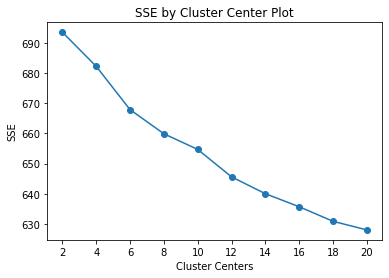

In [81]:
def find_optimal_clusters(data, max_k):
    iters = range(2, max_k+1, 2)
    
    sse = []
    for k in iters:
        sse.append(MiniBatchKMeans(n_clusters=k, init_size=1024, batch_size=2048, random_state=20).fit(data).inertia_)
        print('Fit {} clusters'.format(k))
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')
    
find_optimal_clusters(text_train, 20)

In [82]:
pca = TruncatedSVD(n_components=4)                                
X_reduced_train = pca.fit_transform(X_train)  
print(X_reduced_train)

[[ 0.12633273  0.0842592  -0.08628481 -0.00712939]
 [ 0.27425293 -0.11031436  0.0716638  -0.10580347]
 [ 0.06396786  0.05922225 -0.04965216 -0.00717399]
 ...
 [ 0.07045909  0.08917043  0.02535518 -0.02215079]
 [ 0.14774941  0.29389264 -0.31926792 -0.06959408]
 [ 0.15306046  0.11395688 -0.08816001 -0.00996698]]


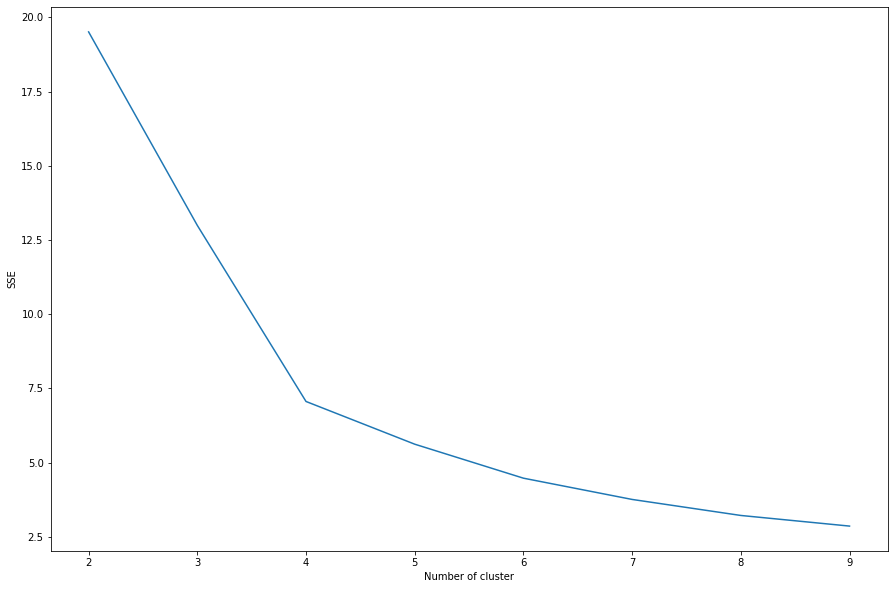

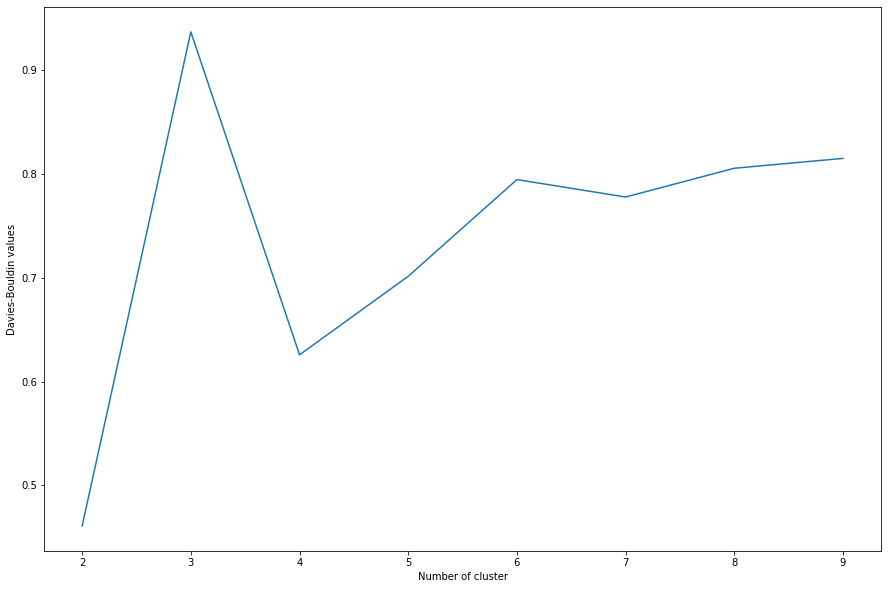

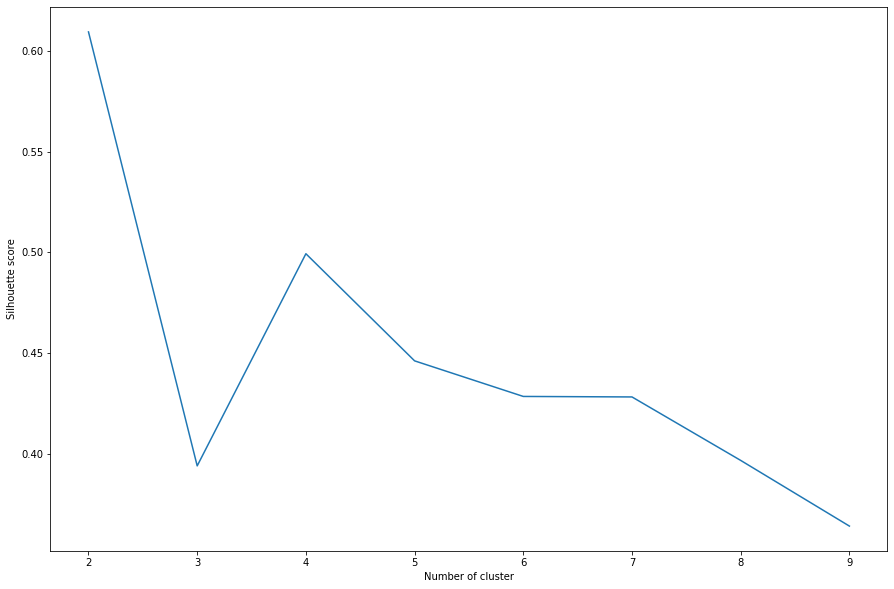

In [83]:
SEED = random.seed(10)
def check_clustering(X, K):
    sse,db,slc = {}, {}, {}
    for k in range(2, K):
        # seed of 10 for reproducibility.
        kmeans = KMeans(n_clusters=k, max_iter=1000,random_state=SEED).fit(X)
        if k == 3: labels = kmeans.labels_
        clusters = kmeans.labels_
        sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
        db[k] = davies_bouldin_score(X,clusters)
        slc[k] = metrics.silhouette_score(X,clusters)


    plt.figure(figsize=(15,10))
    plt.plot(list(sse.keys()), list(sse.values()))
    plt.xlabel("Number of cluster")
    plt.ylabel("SSE")
    plt.show()

    plt.figure(figsize=(15,10))
    plt.plot(list(db.keys()), list(db.values()))
    plt.xlabel("Number of cluster")
    plt.ylabel("Davies-Bouldin values")
    plt.show()

    plt.figure(figsize=(15,10))
    plt.plot(list(slc.keys()), list(slc.values()))
    plt.xlabel("Number of cluster")
    plt.ylabel("Silhouette score")
    plt.show()
check_clustering(X_reduced_train,10)

In [84]:
labels = MiniBatchKMeans(n_clusters=4, init_size=1024, batch_size=2048, random_state=20).fit_predict(X_reduced_train)

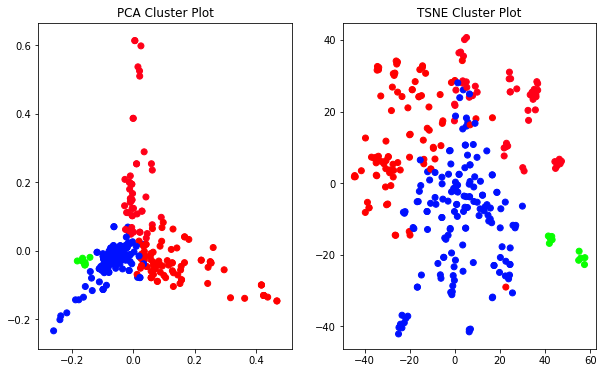

In [85]:
def plot_tsne_pca(data, labels):
    max_label = max(labels)
    max_items = np.random.choice(range(data.shape[0]), size=800, replace=True)
    
    pca = PCA(n_components=2).fit_transform(data[max_items,:].todense())
    tsne = TSNE().fit_transform(PCA(n_components=50).fit_transform(data[max_items,:].todense()))
    
    
    idx = np.random.choice(range(pca.shape[0]), size=300, replace=False)
    label_subset = labels[max_items]
    label_subset = [cm.hsv(i/max_label) for i in label_subset[idx]]
    
    f, ax = plt.subplots(1, 2, figsize=(10, 6))
    
    ax[0].scatter(pca[idx, 0], pca[idx, 1], c=label_subset)
    ax[0].set_title('PCA Cluster Plot')
    
    ax[1].scatter(tsne[idx, 0], tsne[idx, 1], c=label_subset)
    ax[1].set_title('TSNE Cluster Plot')
    
plot_tsne_pca(text_train, labels)

In [86]:
print(metrics.silhouette_score(X_reduced_train, labels, metric='euclidean'))

0.5000607901996785
